In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pickle

In [2]:
from random import sample
import random

from sklearn import tree
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data

In [3]:
df = pd.read_csv('Telescope data.csv')

np.random.seed(42)

In [4]:
print(df['Class'])

0        g
1        g
2        g
3        g
4        g
        ..
19015    h
19016    h
19017    h
19018    h
19019    h
Name: Class, Length: 19020, dtype: object


In [5]:
#one_hot_class = pd.get_dummies(df['Class'])
#df = df.join(one_hot_class)

df['Class_num'] = np.where(df['Class'] == 'g', 1.0, 0.0)

In [6]:
print('Dataset original')
print('Hadron = ' + str(len(df[df['Class'] == 'h'])) )
print('Gamma = ' + str(len(df[df['Class'] == 'g'])) )

#print('Dataset com One Hot Encoding')
#print('Hadron_onehot = ' + str(len(df[df['h'] == 1])) )
#print('Gamma_onehot = ' + str(len(df[df['g'] == 1])) )

print('Dataset com Class numerica')
print('Hadron_num = ' + str(len(df[df['Class_num'] == 0])) )
print('Gamma_num = ' + str(len(df[df['Class_num'] == 1])) )


Dataset original
Hadron = 6688
Gamma = 12332
Dataset com Class numerica
Hadron_num = 6688
Gamma_num = 12332


In [7]:
df = df.drop(['Class'],axis=1)

In [8]:
# Explore the data set
col_names = df.columns.tolist()
df.shape
df.describe

<bound method NDFrame.describe of         fLength    fWidth   fSize   fConc  fConcl     fAsym   fM3Long  \
0       28.7967   16.0021  2.6449  0.3918  0.1982   27.7004   22.0110   
1       31.6036   11.7235  2.5185  0.5303  0.3773   26.2722   23.8238   
2      162.0520  136.0310  4.0612  0.0374  0.0187  116.7410  -64.8580   
3       23.8172    9.5728  2.3385  0.6147  0.3922   27.2107   -6.4633   
4       75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277   28.5525   
...         ...       ...     ...     ...     ...       ...       ...   
19015   21.3846   10.9170  2.6161  0.5857  0.3934   15.2618   11.5245   
19016   28.9452    6.7020  2.2672  0.5351  0.2784   37.0816   13.1853   
19017   75.4455   47.5305  3.4483  0.1417  0.0549   -9.3561   41.0562   
19018  120.5135   76.9018  3.9939  0.0944  0.0683    5.8043  -93.5224   
19019  187.1814   53.0014  3.2093  0.2876  0.1539 -167.3125 -168.4558   

       fM3Trans   fAlpha     fDist  Class_num  
0       -8.2027  40.0920   81.8828       

<AxesSubplot:>

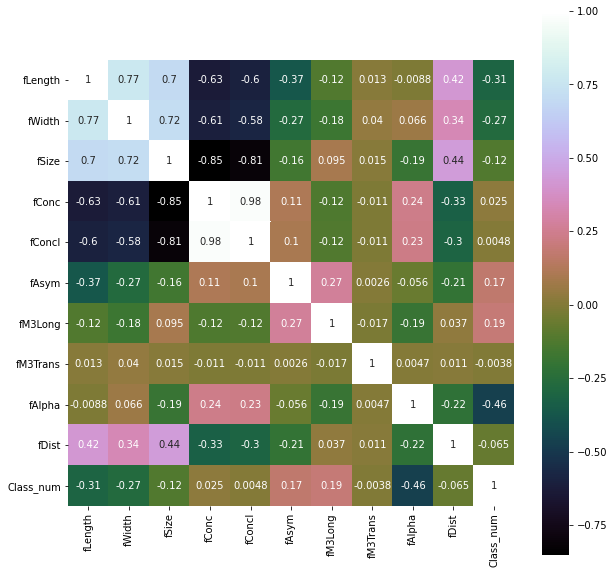

In [9]:
# Correlation heatmap
correlation = df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')


In [10]:
# Pairwise plots (take a 5% sample as CPU intensive)
#df_sample = df.sample(frac=0.05)
#pplot = sns.pairplot(df_sample, hue="Class");


In [11]:
# Split data into train, test and validate
# 80% - train set, 20% - validation set
train, test = np.split( df.sample(frac=1), [int(.8*len(df))])

print(train.shape, test.shape)

# Separate target and predictors
y_train = train['Class_num']
x_train = train.drop(['Class_num'], axis=1)
y_test = test['Class_num']
x_test = test.drop(['Class_num'], axis=1)


(15216, 11) (3804, 11)


In [12]:
# Variable importance / selection
#rf = RandomForestClassifier()
#rf.fit(x_train, y_train)

#print("Features ordenadas por importância no algoritmo de Random Forest:")
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))

In [13]:
# Assign feature importance and sort
#importances = rf.feature_importances_
#std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]


In [14]:
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))

In [15]:
# Plot variable importance
#plt.figure()
#plt.title("Importancia das Features")
#plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")


In [16]:
# Create variable lists and drop
all_vars = x_train.columns.tolist()
top_5_vars = ['fAlpha', 'fLength', 'fWidth', 'fSize', 'fM3Long']
bottom_vars = [cols for cols in all_vars if cols not in top_5_vars]

# Drop less important variables leaving the top_5
x_train    = x_train.drop(bottom_vars, axis=1)
x_test     = x_test.drop(bottom_vars, axis=1)


In [17]:
#rf = RandomForestClassifier()
#rf.fit(x_train, y_train)


In [18]:
#predicted = pd.DataFrame(rf.predict(x_test))
#probs = pd.DataFrame(rf.predict_proba(x_test))


In [19]:
#rf_accuracy = metrics.accuracy_score(y_test, predicted)
#rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])
#rf_confus_matrix = metrics.confusion_matrix(y_test, predicted)
#rf_classification_report = metrics.classification_report(y_test, predicted)
#rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)
#rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)
#rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [20]:
# Instantiate with a max depth of 3
tree_model = tree.DecisionTreeClassifier(max_depth=3)
# Fit a decision tree
tree_model = tree_model.fit(x_train, y_train)
# Training accuracy
tree_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(tree_model.predict(x_test))
probs = pd.DataFrame(tree_model.predict_proba(x_test))

# Store metrics
tree_accuracy = metrics.accuracy_score(y_test, predicted)
tree_roc_auc = metrics.roc_auc_score(y_test, probs[1])
tree_confus_matrix = metrics.confusion_matrix(y_test, predicted)
tree_classification_report = metrics.classification_report(y_test, predicted)
tree_precision = metrics.precision_score(y_test, predicted, pos_label=1)
tree_recall = metrics.recall_score(y_test, predicted, pos_label=1)
tree_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [21]:
predicted

,0
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
3799,1.0
3800,1.0
3801,1.0
3802,0.0


In [22]:
probs

,0,1
0,0.092008,0.907992
1,0.779661,0.220339
2,0.293103,0.706897
3,0.092008,0.907992
4,0.092008,0.907992
...,...,...
3799,0.092008,0.907992
3800,0.092008,0.907992
3801,0.277337,0.722663
3802,0.551746,0.448254


In [23]:
tree_roc_auc

0.8205697414875548

In [24]:
#print(tree_classification_report)

In [25]:
# Evaluate the model using 10-fold cross-validation
tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=3),
                                x_test, y_test, scoring='precision', cv=10)

tree_cv_mean = np.mean(tree_cv_scores)

# Output decision plot
dot_data = tree.export_graphviz(tree_model, out_file=None,
                     feature_names=x_test.columns.tolist(),
                     class_names=['g', 'h'],
                     filled=True, rounded=True,
                     special_characters=True)
#print(dot_data)

graph = graph_from_dot_data(dot_data)
graph.write_png("CTA_DT.png")

True

In [26]:
# EVALUATE
models = pd.DataFrame({
    'Modelo'    : ['Decision Tree'],
    'Acurácia' : [tree_accuracy],
    'Precisão': [tree_precision],
    'Recall'   : [tree_recall],
    'F1'       : [tree_f1],
    'AUC (Curva ROC)' : [tree_roc_auc]
    })

# Create x and y from all data
#y = df['Class_num']
#x = df.drop(['Class_num'], axis=1)


In [27]:
models
#print(tree_confus_matrix)

,Modelo,Acurácia,Precisão,Recall,F1,AUC (Curva ROC)
0,Decision Tree,0.794427,0.813264,0.887586,0.848801,0.82057


In [28]:
# Save model
with open('CTA_DT.pkl', 'wb') as DT_Telescopio:
    pickle.dump(tree_model, DT_Telescopio)

In [29]:
#umaLinha = pd.DataFrame({
#    'fLength':[19.2512],
#    'fWidth':[14.7951],
#    'fSize':[2.2954],
#    'fM3Long':[8.9581],
#    'fAlpha':[51.6492]  
#})


linhaAleatoria = int(random.random()*len(df))
df.iloc[linhaAleatoria]

#print(df.head(1))
#print(umaLinha)

fLength       26.0407
fWidth        15.2710
fSize          2.7020
fConc          0.4786
fConcl         0.2592
fAsym         22.0287
fM3Long       22.1988
fM3Trans      12.8140
fAlpha        59.6370
fDist        132.0060
Class_num      0.0000
Name: 17150, dtype: float64